In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
df_x=  pd.read_csv('C:/Users/bhara/Downloads/x_train.csv')
df_y =  pd.read_csv('C:/Users/bhara/Downloads/y_train.csv')
df_x_test =  pd.read_csv('C:/Users/bhara/Downloads/x_test.csv')
x_input_text = df_x['text']
XTest = df_x_test['text']
Y = df_y['is_positive_sentiment'].values

Y = Y.reshape((Y.shape[0],1))
print(x_input_text)
print(XTest)
print(Y)
Y.shape

0       Oh and I forgot to also mention the weird colo...
1                            THAT one didn't work either.
2                                      Waste of 13 bucks.
3       Product is useless, since it does not have eno...
4       None of the three sizes they sent with the hea...
                              ...                        
2395    The sweet potato fries were very good and seas...
2396    I could eat their bruschetta all day it is dev...
2397                                 Ambience is perfect.
2398    We ordered the duck rare and it was pink and t...
2399         Service was good and the company was better!
Name: text, Length: 2400, dtype: object
0      It only recognizes the Phone as its storage de...
1      Disappointing accessory from a good manufacturer.
2      The one big drawback of the MP3 player is that...
3      This particular model would not work with my M...
4      If the two were seperated by a mere 5+ ft I st...
                             ...     

(2400, 1)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
X = vect.fit_transform(x_input_text)
X_valid = vect.transform(XTest)

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
X1 = X.toarray()
print(X1.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)
X_train_kf = Variable(torch.from_numpy(X_train)).float()
y_train_kf = Variable(torch.from_numpy(y_train)).float()
X_test_var  = Variable(torch.from_numpy(X_test)).float()
y_test_var  = Variable(torch.from_numpy(y_test)).float()
print(X_train_kf.dtype)
print(X_test_var.dtype)
print(y_train_kf.dtype)
print(y_test_var.dtype)

print(X_train_kf.shape)
print(X_test_var.shape)
print(y_train_kf.shape)
print(y_test_var.shape)

(2400, 4510)
(2400, 1)
torch.float32
torch.float32
torch.float32
torch.float32
torch.Size([1920, 4510])
torch.Size([480, 4510])
torch.Size([1920, 1])
torch.Size([480, 1])


In [10]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return F.sigmoid(self.linear(x))
    
loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.001
num_epochs = 2000

model = LogisticRegression(X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

kf = KFold(n_splits=folds, shuffle=True)


In [11]:
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_train_kf)):
    X_train, X_test = X_train_kf[train_index_val], X_train_kf[test_index_val]
    y_train, y_test = y_train_kf[train_index_val], y_train_kf[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train)
        label = y_train.view(-1, 1) 

        loss = criterion(output, label)
        loss_func.append(loss)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test)
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1)).float().mean().item()
        accuracy_list.append(accuracy)
    print(sum(loss_func)/len(loss_func))
print(accuracy_list)

accuracy_avg = sum(accuracy_list) / folds

print(f"Average Accuracy = ", accuracy_avg)


tensor(0.5152, grad_fn=<DivBackward0>)
tensor(0.3813, grad_fn=<DivBackward0>)
tensor(0.3056, grad_fn=<DivBackward0>)
tensor(0.2528, grad_fn=<DivBackward0>)
tensor(0.2126, grad_fn=<DivBackward0>)
tensor(0.1833, grad_fn=<DivBackward0>)
tensor(0.1606, grad_fn=<DivBackward0>)
tensor(0.1418, grad_fn=<DivBackward0>)
tensor(0.1271, grad_fn=<DivBackward0>)
tensor(0.1149, grad_fn=<DivBackward0>)
[0.78125, 0.9114583134651184, 0.9635416865348816, 0.9895833134651184, 0.9739583134651184, 0.9947916865348816, 0.9895833134651184, 0.984375, 1.0, 0.9947916865348816]
Average Accuracy =  0.9583333313465119


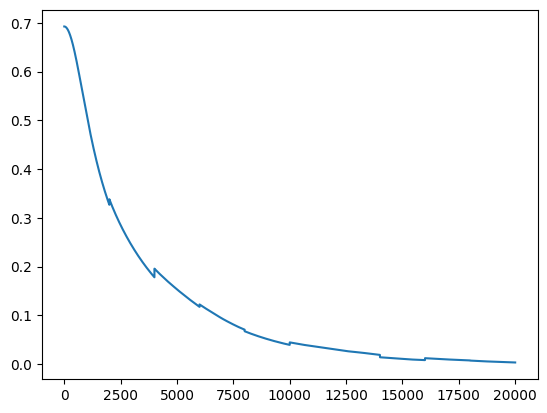

In [13]:
import matplotlib.pyplot as plt
tensor = torch.Tensor(loss_func).detach().numpy()
plt.plot(np.arange(num_epochs * folds), tensor)
plt.show()